In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
import os
PATH = 'drive/My Drive/000 STUDIA/MASTER/'
FILENAME = "datasets.zip"
os.listdir(PATH)

['datasets.zip',
 'read_errors.json',
 'not_enough_parts.json',
 'some_parse_failures.json',
 'parse.json',
 '.ipynb_checkpoints',
 'model_notes-n-chords_dummy',
 'test_idx.json',
 'model_dummy_N+CH_128',
 'model_dummy_N+CH_64',
 'embeddings',
 'model_dummy_N+CH_256',
 'parse_2.json',
 'model_dummy_N+CH_256_stateful',
 'model_dummy_N+CH_512',
 'model_dummy_N+CH_128_stateful',
 'model_dummy_N+CH_64_stateful']

In [11]:
import json

with open(os.path.join(PATH, "parse_2.json"), "r") as handle:
  parsed_data = json.load(handle)

parsed_data.keys()

dict_keys(['notes', 'chords', 'parse_success', 'parse_failures', 'info'])

In [12]:
for k in parsed_data.keys():
  print(k, "_ #", len(parsed_data[k]))

notes _ # 17949
chords _ # 17949
parse_success _ # 17949
parse_failures _ # 5
info _ # 96


In [13]:
flat_notes = [n for ns in parsed_data['notes'] for n in ns]
flat_chords = [c for chs in parsed_data['chords'] for c in chs]

len(flat_notes), len(flat_chords)

(991356, 313492)

In [14]:
import seaborn as sns
sns.set()

import music21 as mc

def name_to_ps(name):
  return mc.pitch.Pitch(name).ps if name != "REST" else -1.0

def ps_to_name(ps):
  return mc.pitch.Pitch(ps).nameWithOctave if ps != -1.0 else "REST"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Notes

### There are overlaps such as C# and D-, so let's translate them into one identifier

In [15]:
def unify_note(note):
  name, duration = note.split('_')
  pitch = ps_to_name(name_to_ps(name))
  return f"{pitch}_{duration}"

notes_translated = []

for melody in parsed_data['notes']:
  notes_translated.append([unify_note(n) for n in melody])

flat_notes_translated = [n for ns in notes_translated for n in ns]

In [16]:
flat_notes_translated[:5]

['REST_15.0', 'F2_0.25', 'G2_0.25', 'B2_0.5', 'REST_17.0']

In [17]:
from collections import Counter

print("# OF DISTINCT NOTES before translation:", len(set(flat_notes)))
print("# OF DISTINCT NOTES after translation:", len(set(flat_notes_translated)))
Counter(flat_notes_translated).most_common(5)

# OF DISTINCT NOTES before translation: 1863
# OF DISTINCT NOTES after translation: 1661


[('C4_0.5', 39385),
 ('E4_0.5', 38217),
 ('C5_0.5', 35759),
 ('A4_0.5', 32959),
 ('G4_0.5', 31281)]

In [18]:
print("COUNTS > 1:", len(list(filter(lambda x : x[1] > 1, Counter(flat_notes_translated).most_common()))))
print("COUNTS = 1:", len(list(filter(lambda x : x[1] == 1, Counter(flat_notes_translated).most_common()))))

COUNTS > 1: 1308
COUNTS = 1: 353


In [19]:
notes_only = [note.split('_')[0] for note in flat_notes_translated]
durations_only = [note.split('_')[1] for note in flat_notes_translated]

print("NUMBER OF DISTINCT NOTE PITCHES:", len(set(notes_only)))
for note_pitch, count in Counter(notes_only).most_common(10):
  print(note_pitch, ":", count)

NUMBER OF DISTINCT NOTE PITCHES: 85
REST : 85855
E4 : 83408
C4 : 82803
C5 : 77188
A4 : 75203
G4 : 68349
D4 : 66719
E5 : 57426
D5 : 52662
B4 : 41237


In [20]:
print("NUMBER OF DISTINCT NOTE DURATIONS:", len(set(durations_only)))
Counter(durations_only).most_common(10)

NUMBER OF DISTINCT NOTE DURATIONS: 131


[('0.5', 434903),
 ('0.25', 197250),
 ('1.0', 183090),
 ('0.75', 49497),
 ('1.5', 42882),
 ('2.0', 32250),
 ('3.0', 11243),
 ('2.5', 9081),
 ('4.0', 7040),
 ('1.25', 5624)]

### Notes frequencies, sorted by their pitch

Text(0.5, 1.0, 'Distribution of notes')

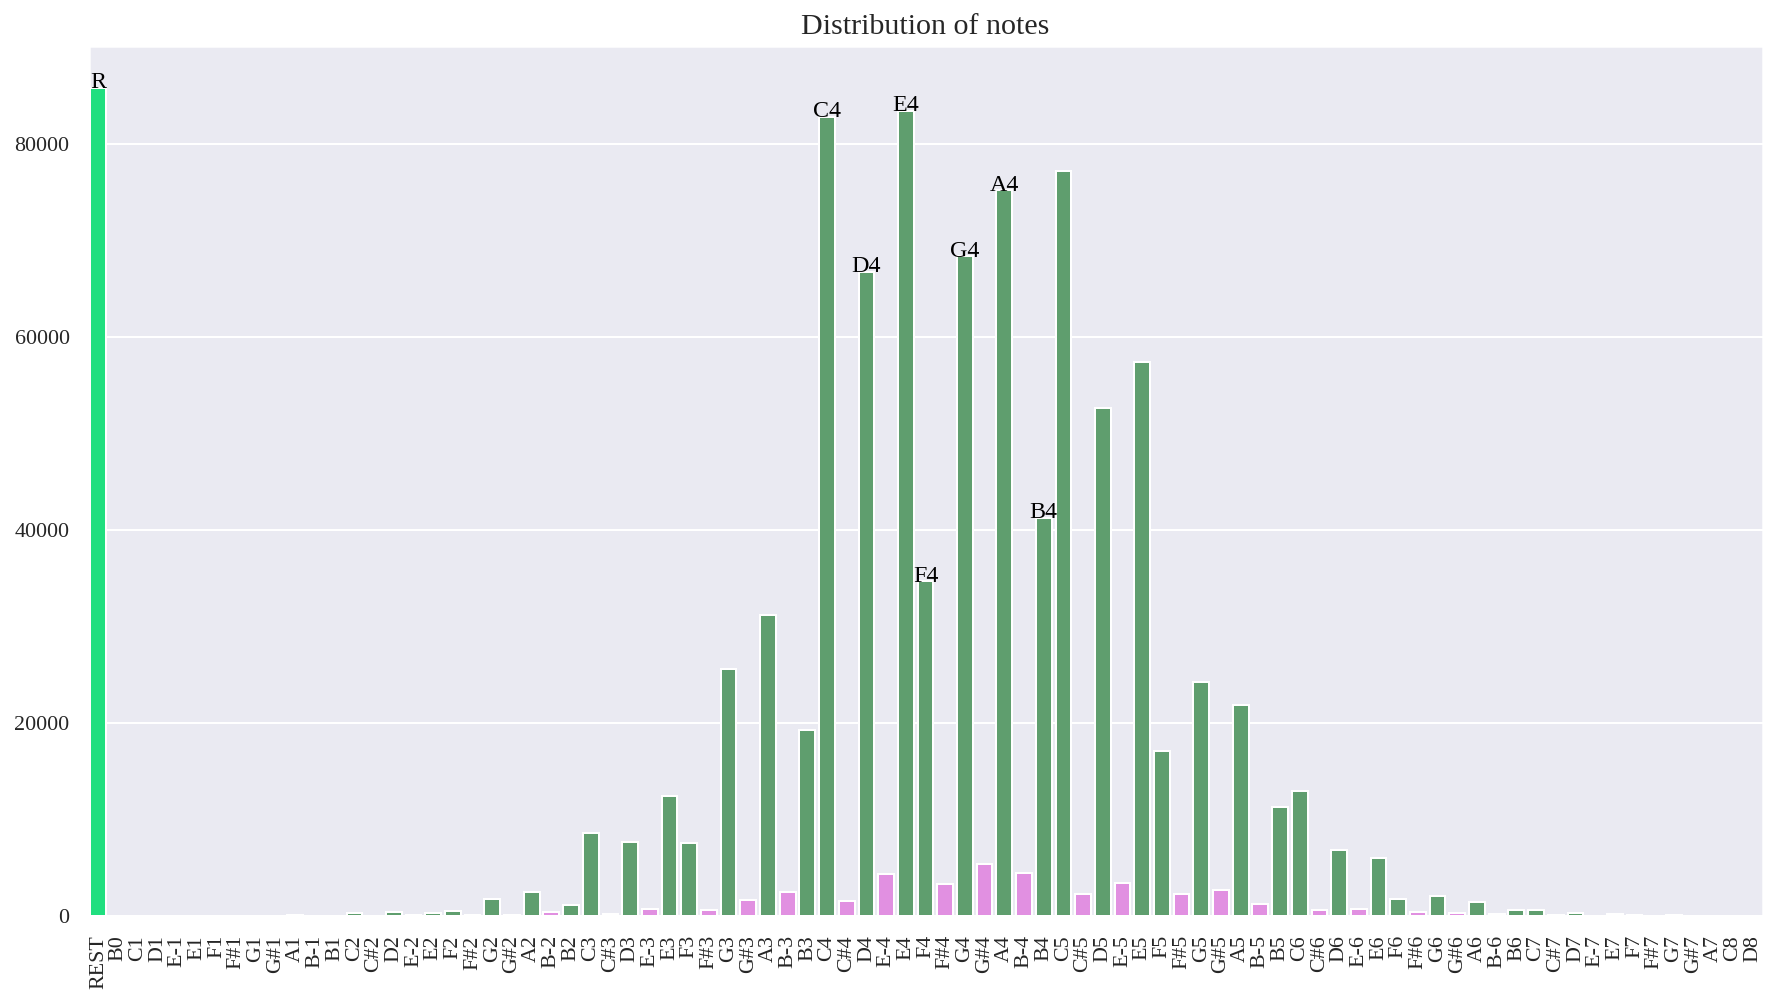

In [21]:
notes_counts = Counter(notes_only).most_common()
notes_counts_sorted = sorted(notes_counts, key=lambda x : name_to_ps(x[0]))

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font="Liberation Serif")

plt.figure(figsize=(15, 8))
colors = []
for note, _ in notes_counts_sorted:
  if note == "REST":
    colors.append("springgreen")
  elif "#" in note or "-" in note:
    colors.append("violet")
  else:
    colors.append("g")

chart = sns.barplot(x=[n[0] for n in notes_counts_sorted], y=[n[1] for n in notes_counts_sorted], palette=colors)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')

for idx, (note, count) in enumerate(notes_counts_sorted):
  if "#" not in note and "-" not in note and "4" in note:
    chart.text(idx, count, note, color='black', ha="center")
  if "REST" in note:
    chart.text(idx, count, "R", color='black', ha="center")


plt.title("Distribution of notes", size=15)

In [22]:

notes_counts[-10:]

[('A7', 8),
 ('F1', 7),
 ('G#7', 6),
 ('E-1', 6),
 ('F#1', 4),
 ('G1', 4),
 ('C8', 4),
 ('G#1', 3),
 ('B0', 1),
 ('D8', 1)]

### Durations frequencies

Text(0.5, 1.0, 'Distribution of 30 most common notes durations')

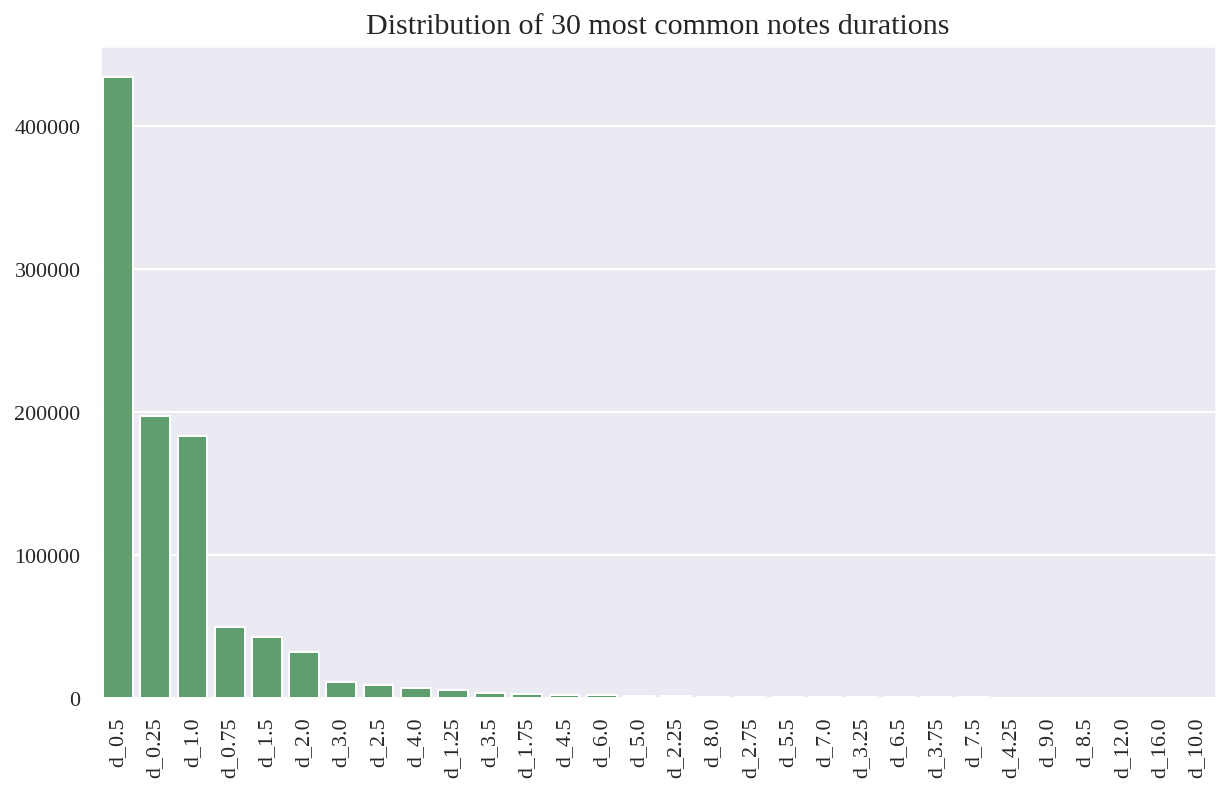

In [23]:
duration_counts = Counter(durations_only).most_common()
duration_counts_clip = duration_counts[:30]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
chart = sns.barplot(x=[f"d_{d[0]}" for d in duration_counts_clip], y=[d[1] for d in duration_counts_clip], color='g')
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.title("Distribution of 30 most common notes durations", size=15)

### `#TODO` Let's represent uncommon durations using the common ones. :) For example, 7 = 2.0 + 2.0 + 2.0 + 1.0 (what kind of algorithm? ...)

## Most common n-grams

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def get_top_ngrams(documents, ngram_range=(2, 2), top_n=10):
  dummy = lambda x : x
  c_vec = CountVectorizer(tokenizer=dummy, preprocessor=dummy, ngram_range=ngram_range)
  X = c_vec.fit_transform(documents)
  terms = c_vec.get_feature_names()
  print("N-gram range:", ngram_range)
  print("Number of terms:", len(terms))
  freqs = X.sum(axis=0).A1
  print("Frequencies sum:", sum(freqs))
  top = sorted(zip(terms, freqs), key=lambda x: -1*x[1])[:top_n]
  return top

def translate_ngrams(ng_text):
  new_text = []
  for t in ng_text.split(' '):
    ps, duration = t.split('_')
    new_text.append(f"{ps_to_name(float(ps))}_{duration}")
  return ' '.join(new_text)

In [25]:
for ng_text, ng_count in get_top_ngrams(notes_translated, ngram_range=(2, 2), top_n=10):
    # new_text = translate_ngrams(ng_text)
    print(ng_count, ":", f"'{ng_text}'")

N-gram range: (2, 2)
Number of terms: 50202
Frequencies sum: 973407
7932 : 'C4_0.5 C4_0.5'
6232 : 'E4_0.5 E4_0.5'
6083 : 'E4_0.5 D4_0.5'
5968 : 'D4_0.5 C4_0.5'
5504 : 'C5_0.5 C5_0.5'
5346 : 'G4_0.5 G4_0.5'
5317 : 'C4_0.5 D4_0.5'
4969 : 'A4_0.5 A4_0.5'
4824 : 'D5_0.5 C5_0.5'
4544 : 'D4_0.5 E4_0.5'


In [26]:
for ng_text, ng_count in get_top_ngrams(notes_translated, ngram_range=(4, 4), top_n=10):
    # new_text = translate_ngrams(ng_text)
    print(ng_count, ":", f"'{ng_text}'")

N-gram range: (4, 4)
Number of terms: 452888
Frequencies sum: 937543
1414 : 'C4_0.5 C4_0.5 C4_0.5 C4_0.5'
1031 : 'C5_0.5 C5_0.5 C5_0.5 C5_0.5'
993 : 'E4_0.5 E4_0.5 E4_0.5 E4_0.5'
857 : 'A4_0.5 A4_0.5 A4_0.5 A4_0.5'
791 : 'G4_0.5 G4_0.5 G4_0.5 G4_0.5'
709 : 'C4_0.25 C4_0.25 C4_0.25 C4_0.25'
696 : 'A4_0.25 A4_0.25 A4_0.25 A4_0.25'
655 : 'E5_0.5 E5_0.5 E5_0.5 E5_0.5'
642 : 'D4_0.5 D4_0.5 D4_0.5 D4_0.5'
609 : 'C5_0.25 C5_0.25 C5_0.25 C5_0.25'


### Without durations

In [27]:
notes_without_durations = [["REST" if "R" in n.split('_')[0] else mc.note.Note(n.split('_')[0]).name for n in notes] for notes in notes_translated]
for ng_text, ng_count in get_top_ngrams(notes_without_durations, ngram_range=(2, 2), top_n=10):
    # new_text = translate_ngrams(ng_text)
    print(ng_count, ":", f"'{ng_text}'")

N-gram range: (2, 2)
Number of terms: 169
Frequencies sum: 973407
44901 : 'C C'
39727 : 'D C'
38983 : 'E D'
34931 : 'E E'
33728 : 'C D'
30680 : 'D E'
29496 : 'A A'
28591 : 'G G'
24935 : 'D D'
24528 : 'C B'


In [28]:
for ng_text, ng_count in get_top_ngrams(notes_without_durations, ngram_range=(5, 5), top_n=10):
    # new_text = translate_ngrams(ng_text)
    print(ng_count, ":", f"'{ng_text}'")

N-gram range: (5, 5)
Number of terms: 73285
Frequencies sum: 919632
6622 : 'C C C C C'
4701 : 'E E E E E'
4665 : 'A A A A A'
3560 : 'G G G G G'
2719 : 'D D D D D'
1736 : 'C D E D C'
1430 : 'REST C C C C'
1378 : 'E D C D E'
1352 : 'B B B B B'
1352 : 'F F F F F'


## Without notes :)

In [29]:
notes_without_pitches = [[n.split('_')[1] for n in notes] for notes in notes_translated]
for ng_text, ng_count in get_top_ngrams(notes_without_pitches, ngram_range=(2, 2), top_n=10):
    # new_text = translate_ngrams(ng_text)
    print(ng_count, ":", f"'{ng_text}'")

N-gram range: (2, 2)
Number of terms: 1168
Frequencies sum: 973407
279027 : '0.5 0.5'
128516 : '0.25 0.25'
80282 : '1.0 1.0'
62512 : '0.5 1.0'
58559 : '1.0 0.5'
39294 : '0.25 0.5'
38957 : '0.5 0.25'
17281 : '1.5 0.5'
16737 : '0.75 0.75'
16004 : '0.5 1.5'


In [30]:
for ng_text, ng_count in get_top_ngrams(notes_without_pitches, ngram_range=(5, 5), top_n=10):
    # new_text = translate_ngrams(ng_text)
    print(ng_count, ":", f"'{ng_text}'")

N-gram range: (5, 5)
Number of terms: 43613
Frequencies sum: 919632
114309 : '0.5 0.5 0.5 0.5 0.5'
65972 : '0.25 0.25 0.25 0.25 0.25'
18098 : '1.0 1.0 1.0 1.0 1.0'
15675 : '0.5 0.5 0.5 0.5 1.0'
13531 : '1.0 0.5 0.5 0.5 0.5'
12232 : '0.5 0.5 1.0 0.5 0.5'
10580 : '0.5 0.5 0.5 1.0 0.5'
9324 : '0.5 1.0 0.5 0.5 0.5'
7920 : '0.5 0.5 0.5 1.0 1.0'
6783 : '0.25 0.25 0.25 0.25 0.5'


# Chords

In [31]:
len(set(flat_chords))

5621

#### Let's truncate some 5-notes long chords to unify them a little bit more

> `TODO` : opisać jak zredukowano liczbę różnych akordów! Krok 'zerowy' - obcinamy akord do max 4 dźwięków. Najpierw - zostawiono tak jak były, jedynie ujednolicono dźwięki o tej samej wysokości do jednego 'tokenu'. Dalej, możemy pominąć OKTAWY. Wówczas okazało się że możemy (powinniśmy) też posortować dźwięki od najniższego do najwyższego ???

In [32]:
TRUNCATE_CHORD = 4
def unify_chord(chord):
  names, duration = chord.split('_')
  new_names = []
  for name in names.split('.')[:TRUNCATE_CHORD]:
    # new_names.append(str(name_to_ps(name)))
    new_names.append(ps_to_name(name_to_ps(name)))
  new_names = map(lambda x : str(x)[0], new_names)
  return f"{'+'.join(new_names)}_{duration}"

chords_translated = []
for melody in parsed_data['chords']:
  chords_translated.append([unify_chord(n) for n in melody])

flat_chords_translated = [n for ns in chords_translated for n in ns]

# print("# OF DISTINCT CHORDS before translation:", len(set(flat_chords)))
# print("# OF DISTINCT CHORDS after translation:", len(set(flat_chords_translated)))

flat_chords_translated_without_duration = [n.split("_")[0] for ns in chords_translated for n in ns]
print(len(set(flat_chords_translated_without_duration)))

Counter(flat_chords_translated).most_common(5)

294


[('A+C+E_4.0', 12562),
 ('C+E+G_4.0', 12121),
 ('F+A+C_4.0', 11747),
 ('G+B+D_4.0', 10462),
 ('G+B+D_2.0', 8535)]

In [33]:
Counter(flat_chords_translated_without_duration).most_common(5)

[('A+C+E', 43378),
 ('C+E+G', 39316),
 ('G+B+D', 38391),
 ('F+A+C', 37543),
 ('R', 17706)]

#### Many chords occur only once :(

In [34]:
print("COUNTS > 1:", len(list(filter(lambda x : x[1] > 1, Counter(flat_chords_translated).most_common()))))
print("COUNTS = 1:", len(list(filter(lambda x : x[1] == 1, Counter(flat_chords_translated).most_common()))))

COUNTS > 1: 2428
COUNTS = 1: 770


In [35]:
print("COUNTS > 1:", len(list(filter(lambda x : x[1] > 1, Counter(flat_chords_translated_without_duration).most_common()))))
print("COUNTS = 1:", len(list(filter(lambda x : x[1] == 1, Counter(flat_chords_translated_without_duration).most_common()))))

COUNTS > 1: 267
COUNTS = 1: 27


#### Most common chords without durations

In [36]:
chord_notes_only = [chord.split('_')[0] for chord in flat_chords_translated]
chord_durations_only = [chord.split('_')[1] for chord in flat_chords_translated]

def _tr_note_pitches(note_pitches):
  tr = []
  for ps in note_pitches.split('+'):
    tr.append(ps_to_name(float(ps))[0])
  return ' '.join(tr)

def _chord_to_pitchedCommonName(chord):
  if not chord.startswith("R"):
    return mc.chord.Chord(chord.split('+')).pitchedCommonName
  else:
    return ""

print("NUMBER OF DISTINCT CHORD PITCHES:", len(set(chord_notes_only)))
for note_pitch, count in Counter(chord_notes_only).most_common(15):
  print(note_pitch, ":", count, _chord_to_pitchedCommonName(note_pitch))



NUMBER OF DISTINCT CHORD PITCHES: 294
A+C+E : 43378 A-minor triad
C+E+G : 39316 C-major triad
G+B+D : 38391 G-major triad
F+A+C : 37543 F-major triad
R : 17706 
D+F+A : 16468 D-minor triad
E+G+B : 15922 E-minor triad
F+A+C+E : 6911 F-major seventh chord
A+C+E+G : 6548 A-minor seventh chord
D+F+A+C : 6331 D-minor seventh chord
E+G+B+D : 5922 E-minor seventh chord
B+D+F : 4989 B-diminished triad
G+C+E : 4124 C-major triad
E+G+C : 3971 C-major triad
G+B+D+F : 3537 G-dominant seventh chord


Text(0.5, 1.0, 'Top 30 chords')

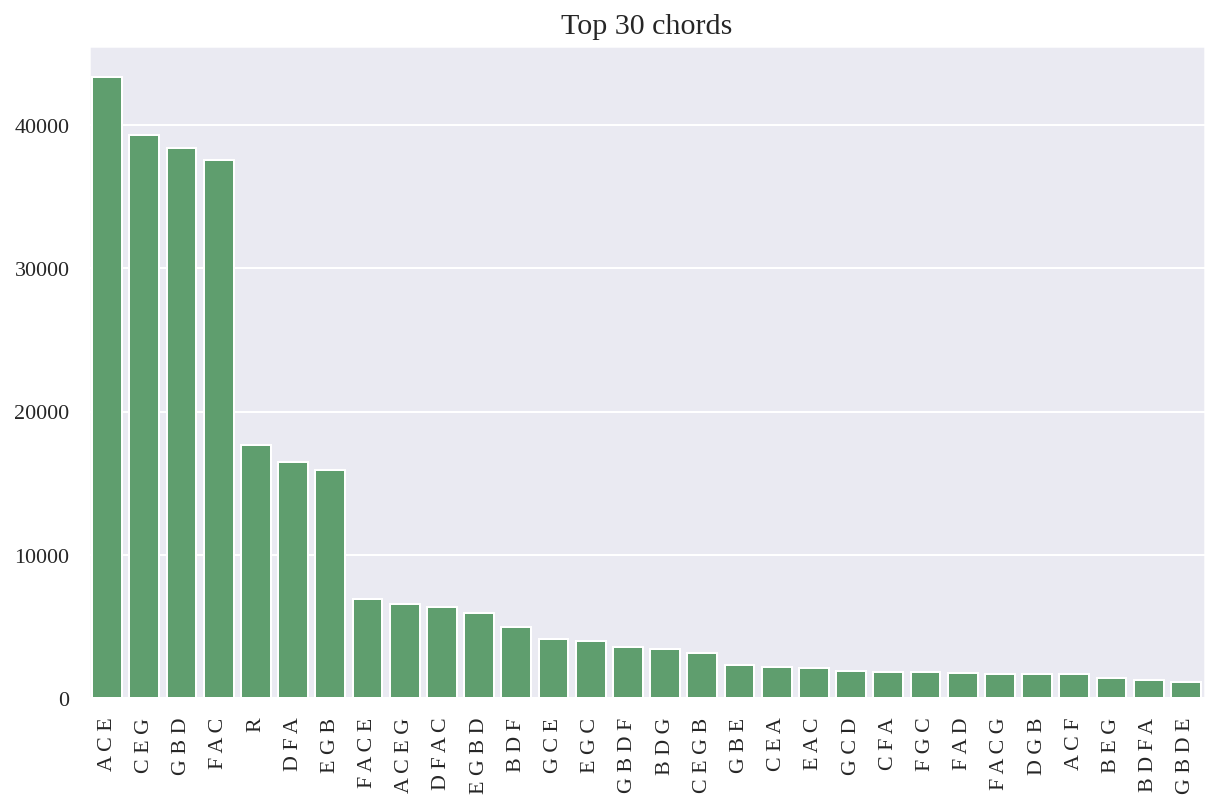

In [37]:
chords_counts = Counter(chord_notes_only).most_common(30)

plt.figure(figsize=(10, 6))
chart = sns.barplot(x=[n[0].replace("+", " ") for n in chords_counts], y=[n[1] for n in chords_counts], ci=None, color="g")
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.title("Top 30 chords", size=15)

#### Chords lengths (after truncation)

In [38]:
import numpy as np

chord_lengths = [len(ch.split('+')) for ch in chord_notes_only]
np.mean(chord_lengths)

3.0669522667245097

In [39]:
Counter(chord_lengths).most_common()

[(3, 235486), (4, 58526), (1, 18057), (2, 1423)]

In [40]:
print("NUMBER OF DISTINCT CHORD DURATIONS:", len(set(chord_durations_only)))
Counter(chord_durations_only).most_common(20)

NUMBER OF DISTINCT CHORD DURATIONS: 82


[('4.0', 79579),
 ('2.0', 60483),
 ('1.0', 39557),
 ('0.5', 36694),
 ('1.5', 23556),
 ('3.0', 15530),
 ('8.0', 10565),
 ('0.75', 10516),
 ('2.5', 8435),
 ('0.25', 7535),
 ('6.0', 6484),
 ('3.5', 3443),
 ('4.5', 2722),
 ('5.0', 1573),
 ('12.0', 1036),
 ('1.75', 851),
 ('1.25', 693),
 ('16.0', 664),
 ('2.25', 642),
 ('7.0', 547)]

# --------------------
## TODO: Split songs into smaller parts
Let's select length of smaller parts by looking at most common chords durations. For example, 16.0? If something is longer than 16.0, then just drop it.

## Let's investigate durations of the songs, looking at chords

In [41]:
def calculate_duration(melody):
  return sum([float(m.split('_')[-1]) for m in melody])

durations = [calculate_duration(chords) for chords in chords_translated]
durations[:10]

[64.0, 61.0, 32.0, 32.0, 96.0, 132.0, 66.0, 96.0, 64.0, 80.0]

In [42]:
import pandas as pd
tmp_df = pd.DataFrame({"d": durations})
tmp_df.describe()

,d
count,17949.000000
mean,45.649577
std,25.117910
min,0.500000
25%,32.000000
50%,33.000000
75%,64.000000
max,544.000000


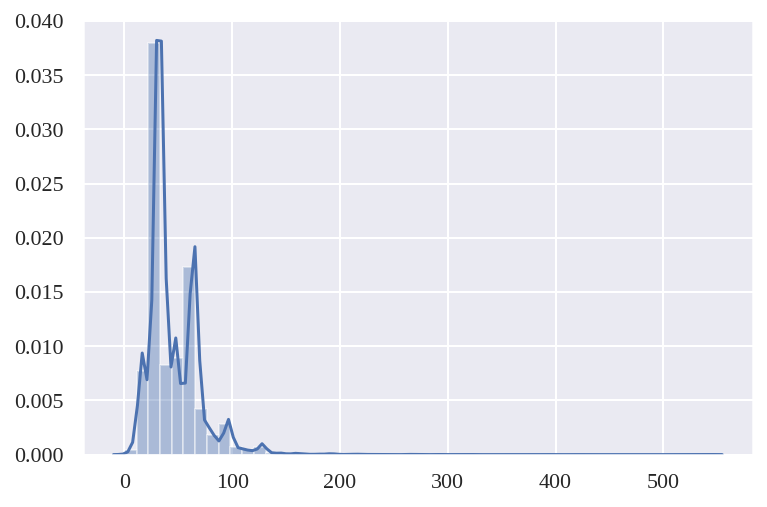

In [43]:
sns.distplot(durations)

In [44]:
tmp_df[tmp_df.d < 8.0].shape

(23, 1)

## Let's find note-chords ALIGNMENTS
> We can infer from the dataset, which note can occur within which chord

In [45]:
chord_to_note = {}

for notes, chords in zip(notes_translated, chords_translated):
  note_off = 0.0
  chord_off = 0.0
  n_idx = 0
  ch_idx = 0
  while ch_idx < len(chords):
    chord_name = chords[ch_idx].split("_")[0]
    chord_duration = float(chords[ch_idx].split("_")[1])
    chord_off += chord_duration
    if chord_name not in chord_to_note:
      chord_to_note[chord_name] = []
    while note_off < chord_off and n_idx < len(notes):
      note_name = notes[n_idx].split("_")[0]
      if note_name != "REST":
        note_name = mc.note.Note(note_name).name
      note_duration = float(notes[n_idx].split("_")[1])
      chord_to_note[chord_name].append(note_name)
      note_off += note_duration
      n_idx += 1
    ch_idx += 1


In [46]:
Counter(chord_to_note["C+E+G"]).most_common()

[('C', 32126),
 ('E', 30643),
 ('G', 23563),
 ('D', 14105),
 ('REST', 11673),
 ('A', 7103),
 ('F', 5285),
 ('B', 3825),
 ('E-', 1020),
 ('B-', 674),
 ('F#', 382),
 ('G#', 340),
 ('C#', 239)]

In [47]:
Counter(chord_to_note["D+F+A+E"]).most_common()

[('E', 405),
 ('A', 217),
 ('C', 207),
 ('D', 193),
 ('REST', 133),
 ('F', 97),
 ('G', 94),
 ('B', 46),
 ('F#', 28),
 ('E-', 10),
 ('C#', 4),
 ('G#', 3)]

## TODO: Simple validator, check if chord+note was played looking at the dataset. If it was, it probably fits. 

Use probabilities? Less likely : less probable. Later on, divide by number of notes+chords pairs. If it's close to one, then we played most probable note most of the time. 

Other approach: check only first note, most frequent. Or three most frequent? :D

In [48]:
all_intervals = []

def _to_pitch(note):
  if "REST" in note:
    return -1
  else:
    return mc.note.Note(note.split('_')[0]).pitch.ps 
  
for notes in notes_translated:
  intervals = []

  prev_pitch = None
  for note in notes:
    if "REST" not in note:
      next_pitch = _to_pitch(note)
      if prev_pitch:
        intervals.append(next_pitch-prev_pitch)
      prev_pitch = next_pitch

  all_intervals.append(intervals)

all_intervals[0][:5]

[2.0, 4.0, 20.0, 0.0, 0.0]

Text(0.5, 1.0, 'Distribution of intervals\n(clipped to range -20.0 and 20.0)')

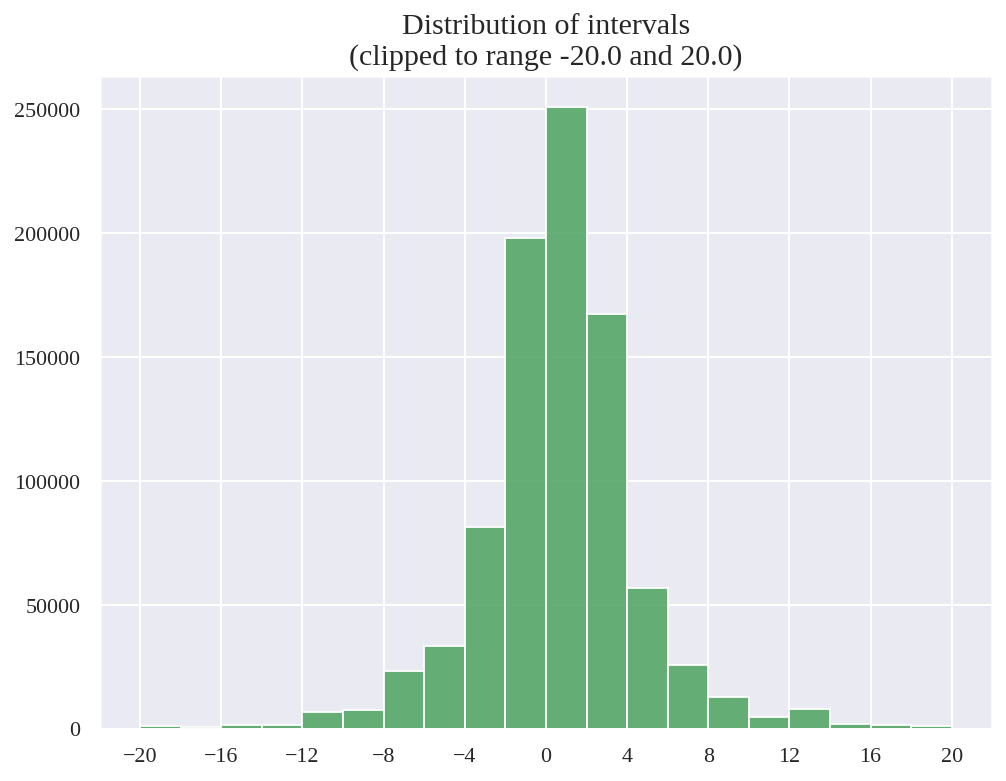

In [49]:
# ALL
plt.figure(figsize=(8, 6))
bs = [-20, *[i for i in range(-18, 20, 2)], 20]
sns.distplot([ival for intervals in all_intervals for ival in intervals], kde=False, bins=bs, hist=True, color="g", hist_kws=dict(alpha=0.9))
# plt.xlim((-20, 20))
_ = plt.xticks(bs[::2])
plt.title("Distribution of intervals\n(clipped to range -20.0 and 20.0)", size=15)

Text(0.5, 0.98, 'Interval distributions in songs of different artists')

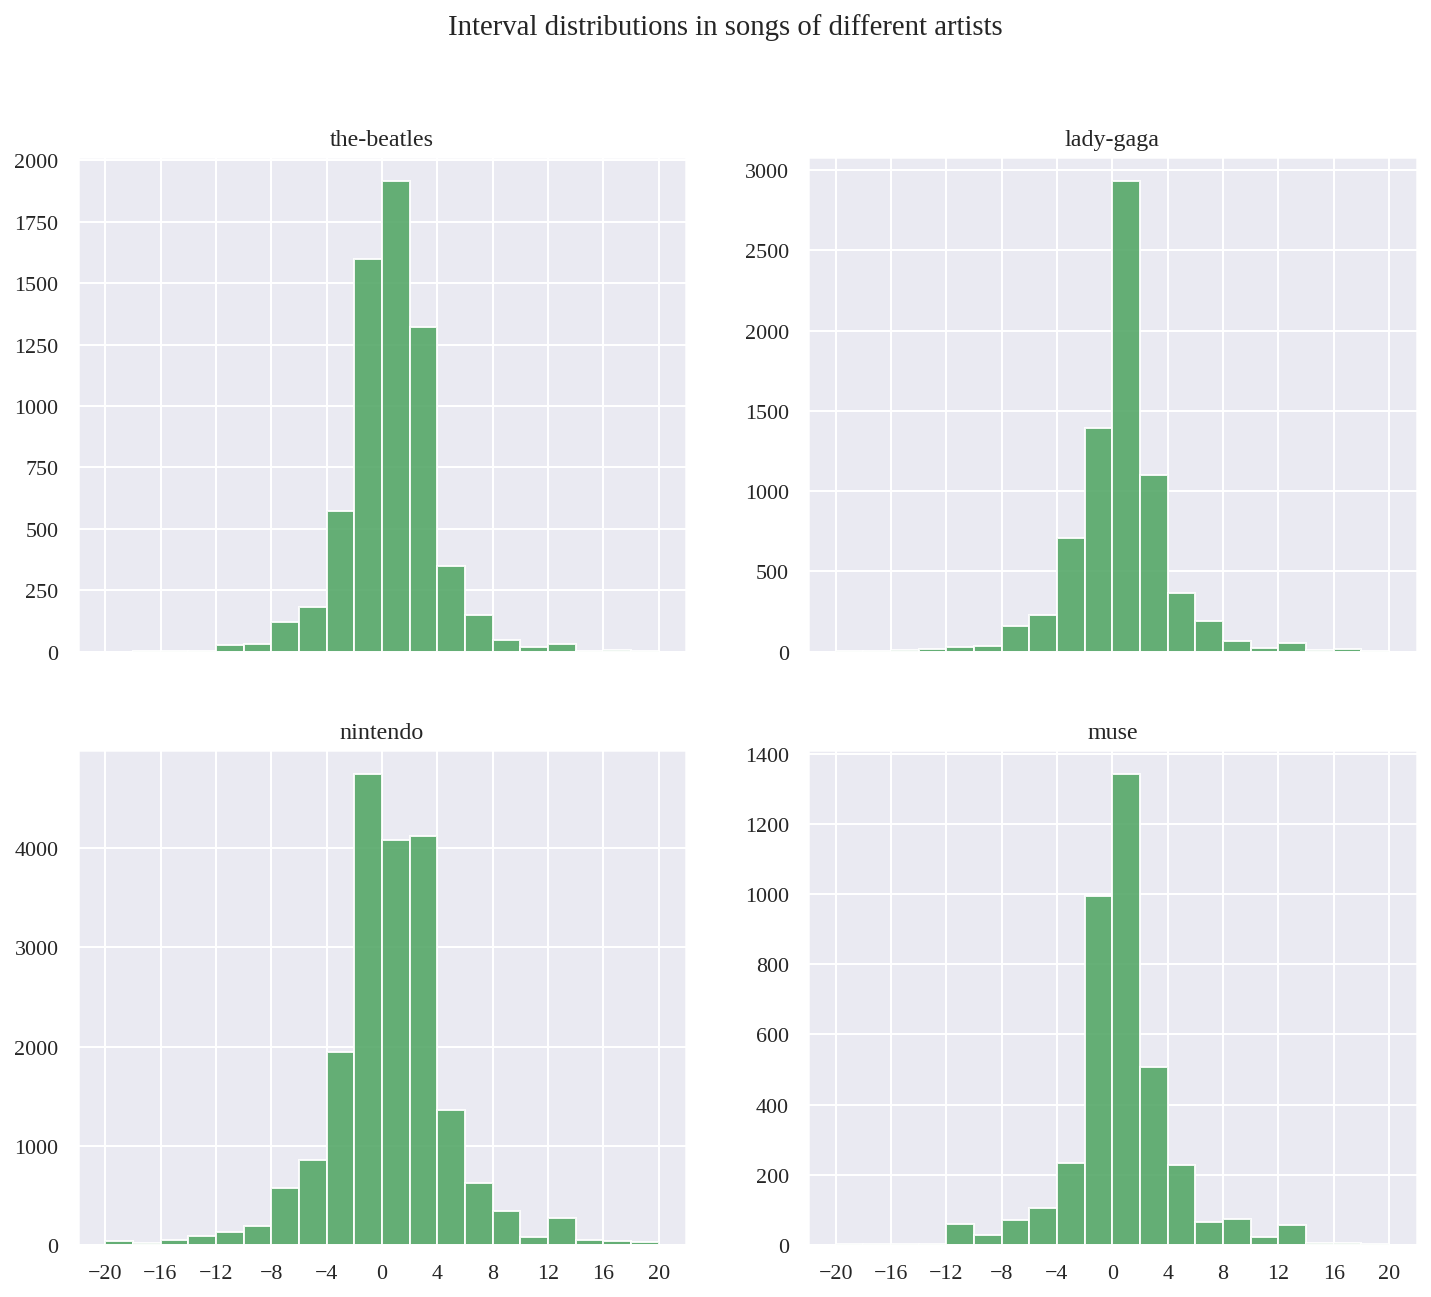

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [57]:
f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
artists = ["muse", "nintendo", "lady-gaga", "the-beatles"]

for i in range(2):
  for j in range(2):

    tmp_intervals = []
    art = artists.pop()
    for idx, path in enumerate(parsed_data['parse_success']):
      if f"/{art}/" in path:
        tmp_intervals.append(all_intervals[idx])

    # ALL
    plt.figure(figsize=(8, 6))
    bs = [-20, *[i for i in range(-18, 20, 2)], 20]
    sns.distplot([ival for intervals in tmp_intervals for ival in intervals], ax=axes[i, j], kde=False, bins=bs, hist=True, color="g", hist_kws=dict(alpha=0.9))
    axes[i, j].set_title(art)
    axes[i, j].set_xticks(bs[::2])
    # _ = plt.xticks(bs[::2])

f.suptitle("Interval distributions in songs of different artists")


(-20.0, 20.0)

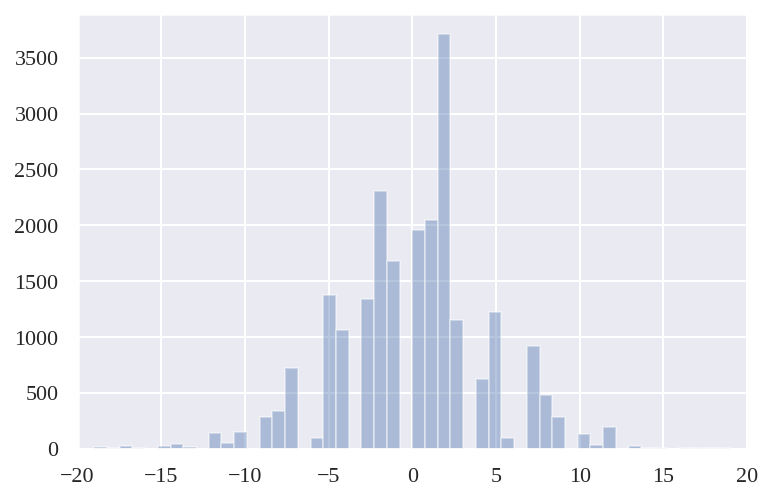

In [51]:
tmp_intervals = []
for idx, path in enumerate(parsed_data['parse_success']):
  if "/zun/" in path:
    tmp_intervals.append(all_intervals[idx])

sns.distplot([ival for intervals in tmp_intervals for ival in intervals if ival > -20.0 and ival < 20.0], kde=False, bins=50, hist=True)
plt.xlim((-20, 20)) 

(-20.0, 20.0)

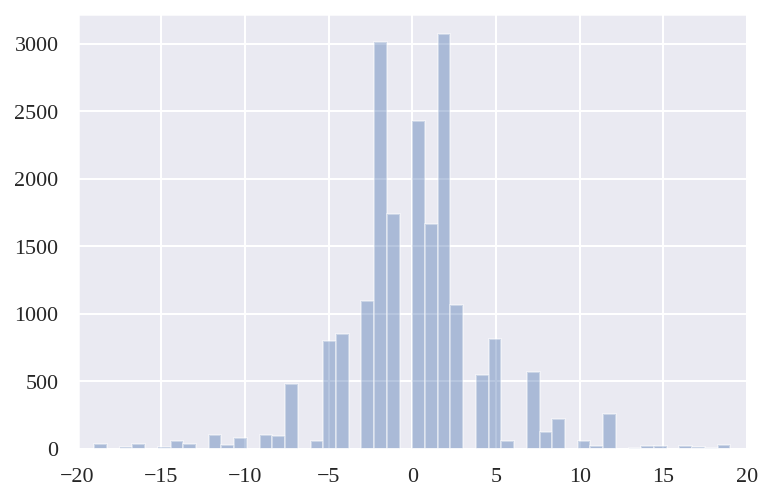

In [52]:
tmp_intervals = []
for idx, path in enumerate(parsed_data['parse_success']):
  if "/nintendo/" in path:
    tmp_intervals.append(all_intervals[idx])

sns.distplot([ival for intervals in tmp_intervals for ival in intervals if ival > -20.0 and ival < 20.0], kde=False, bins=50, hist=True)
plt.xlim((-20, 20)) 

(-20.0, 20.0)

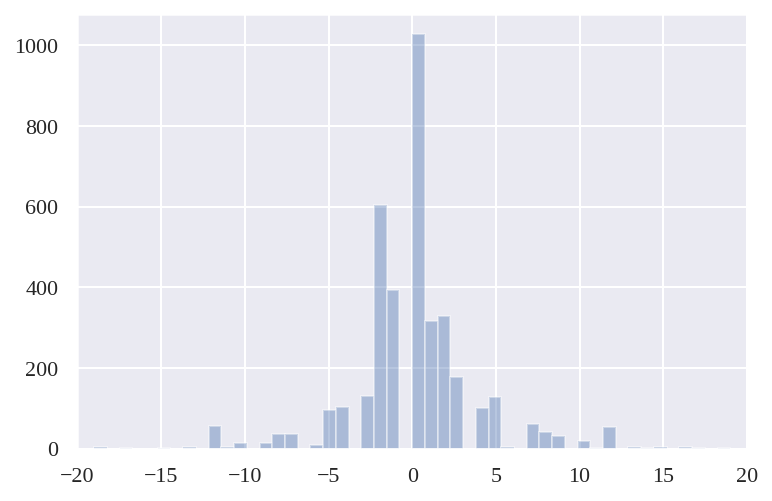

In [53]:
tmp_intervals = []
for idx, path in enumerate(parsed_data['parse_success']):
  if "/muse/" in path:
    tmp_intervals.append(all_intervals[idx])

sns.distplot([ival for intervals in tmp_intervals for ival in intervals if ival > -20.0 and ival < 20.0], kde=False, bins=50, hist=True)
plt.xlim((-20, 20)) 

### Same but for duration intervals

In [54]:
all_duration_intervals = []

def _to_duration(note):
  return float(note.split("_")[1])
  
for notes in notes_translated:
  intervals = []

  prev_d = None
  for note in notes:
    next_d = _to_duration(note)
    if prev_d:
      intervals.append(next_d-prev_d)
    prev_d = next_d

  all_duration_intervals.append(intervals)

all_duration_intervals[0][:5]

[-14.75, 0.0, 0.25, 16.5, -16.5]

(-20.0, 20.0)

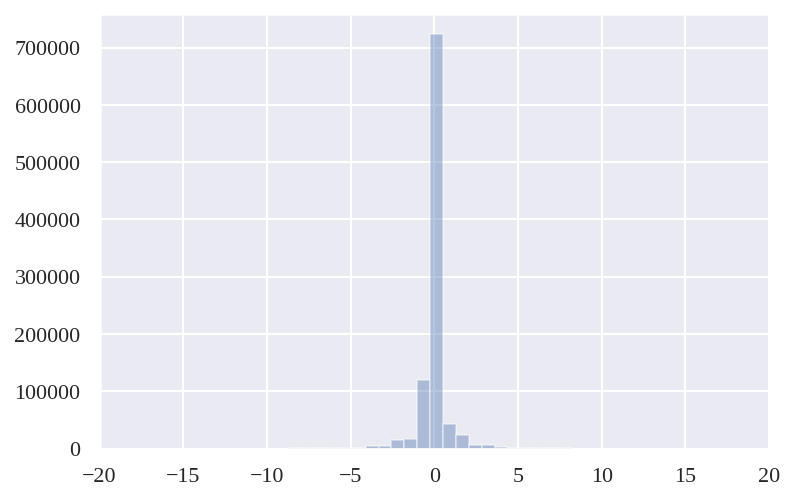

In [55]:
# ALL
sns.distplot([ival for intervals in all_duration_intervals for ival in intervals if ival > -20.0 and ival < 20.0], kde=False, bins=50, hist=True)
plt.xlim((-20, 20))

(-20.0, 20.0)

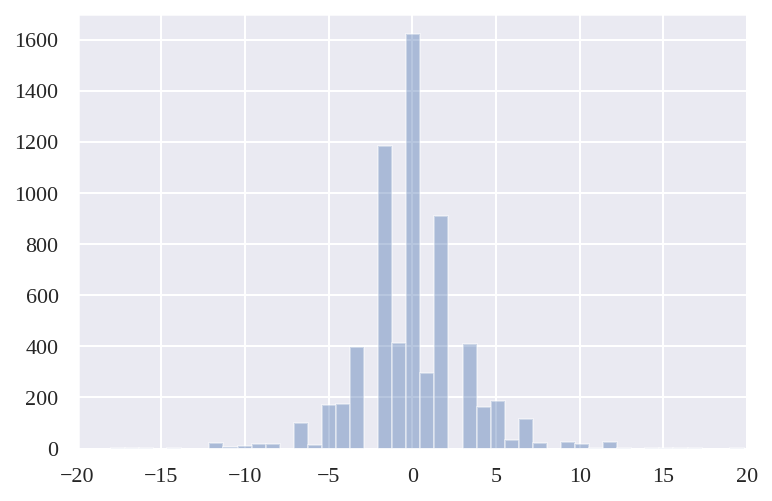

In [56]:
tmp_intervals = []
for idx, path in enumerate(parsed_data['parse_success']):
  if "/the-beatles/" in path:
    tmp_intervals.append(all_intervals[idx])

sns.distplot([ival for intervals in tmp_intervals for ival in intervals], kde=False, bins=50, hist=True)
plt.xlim((-20, 20))

(-20.0, 20.0)

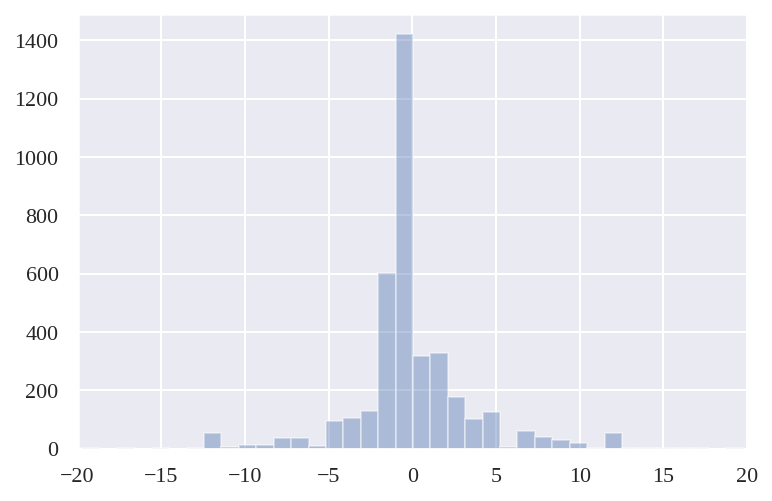

In [57]:
tmp_intervals = []
for idx, path in enumerate(parsed_data['parse_success']):
  if "/muse/" in path:
    tmp_intervals.append(all_intervals[idx])

sns.distplot([ival for intervals in tmp_intervals for ival in intervals], kde=False, bins=50, hist=True)
plt.xlim((-20, 20))

## ? Split into `16.0`? `32.0`?

In [58]:
def split_into_parts(melody, length=16.0):
  parts = []
  current_part = []
  current_duration = 0.0
  for m in melody:
    dur = float(m.split('_')[-1])
    # if dur > length:
      # raise Exception("Note duration exceeds the part length. ABORT :)")
    current_duration += dur
    if current_duration < length:
      current_part.append(m)
    elif current_duration == length:
      current_part.append(m)
      parts.append(current_part)
      current_part = []
      current_duration = 0.0
    else:
      split1 = length - (current_duration - dur)
      split2 = current_duration - length
      current_part.append(m.replace('_'+str(dur), '_'+str(split1)))
      parts.append(current_part)
      current_part = [m.replace('_'+str(dur), '_'+str(split2))]
      current_duration = split2

  if current_part:
    parts.append(current_part)
    # pad with some ... ? end of melody ?
  return parts

In [ ]:
melody_into_parts = []
chord_into_parts = []
song_indices = []
skips = []
LENGTH = 8

max_m_split = 0
max_ch_split = 0

for idx, (melody, chords) in enumerate(list(zip(notes_translated, chords_translated))):
  try:
    m_split = split_into_parts(melody, length=LENGTH)
    ch_split = split_into_parts(chords, length=LENGTH)
    max_m_split = max(max_m_split, len(m_split))
    max_ch_split = max(max_ch_split, len(ch_split))

    for i in range(min(len(ch_split), len(m_split))):
      melody_into_parts.append(m_split[i])
      chord_into_parts.append(ch_split[i])
      song_indices.append(idx)
  except Exception as e:
    if 'Note duration exceeds the part length' in str(e):
      # print("SKIP:", e)
      skips.append(idx)
    else:
      print("???", e)
      break

print(len(melody_into_parts))
print(len(skips))
print(max_m_split, max_ch_split)


102143
0
67 68


# TrYING a dummy model

In [ ]:
X_raw, y_raw = [], []
NOTES_WINDOW = 8

for sample in notes_translated:
  for i in range(NOTES_WINDOW, len(sample)):
    notes_slice = sample[i-NOTES_WINDOW:i]
    input_pitches = []
    input_durations = []
    for n in notes_slice:
      pitch, duration = n.split('_')
      input_pitches.append(float(pitch))
      input_durations.append(float(duration))
    X_raw.append([*input_pitches, *input_durations])
    y_raw.append(sample[i])

## TODO: Try different normalization! What makes sense?

In [ ]:
X = np.reshape(X_raw, (len(X_raw), NOTES_WINDOW*2, 1))
X[:, :8, :] = (X[:, :8, :] - np.mean(X[:, :8, :])) / np.std(X[:, :8, :])
X[:, 8:, :] = (X[:, 8:, :] - np.mean(X[:, 8:, :])) / np.std(X[:, 8:, :])

In [ ]:
from keras.utils import np_utils

all_tokens = list(set([n for notes in notes_translated for n in notes]))
token_to_id = {token : idx for idx, token in enumerate(all_tokens)}

y = np_utils.to_categorical([token_to_id[token] for token in y_raw])

## Start with dummy approach from https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [ ]:
X.shape, y.shape

((848270, 16, 1), (848270, 1661))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# define the checkpoint
# filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]

# fit the model
model.fit(X, y, epochs=20, batch_size=64, verbose=1)#, callbacks=callbacks_list)

Epoch 1/20
13255/13255 [==============================] - 53s 4ms/step - loss: 3.7114
Epoch 2/20
13255/13255 [==============================] - 52s 4ms/step - loss: 3.4036
Epoch 3/20
13255/13255 [==============================] - 53s 4ms/step - loss: 3.3136
Epoch 4/20
13255/13255 [==============================] - 54s 4ms/step - loss: 3.2544
Epoch 5/20
13255/13255 [==============================] - 53s 4ms/step - loss: 3.2081
Epoch 6/20
13255/13255 [==============================] - 53s 4ms/step - loss: 3.1690
Epoch 7/20
13255/13255 [==============================] - 53s 4ms/step - loss: 3.1366
Epoch 8/20
13255/13255 [==============================] - 53s 4ms/step - loss: 3.1088
Epoch 9/20
13255/13255 [==============================] - 52s 4ms/step - loss: 3.0828
Epoch 10/20
13255/13255 [==============================] - 52s 4ms/step - loss: 3.0605
Epoch 11/20
13255/13255 [==============================] - 52s 4ms/step - loss: 3.0402
Epoch 12/20
13255/13255 [===========================